In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
try:
  import transformers
except ModuleNotFoundError:
  !pip install transformers
  import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, get_scheduler
from tqdm import tqdm
from sklearn.model_selection import train_test_split

try:
  import torchmetrics
except ModuleNotFoundError:
  !pip install torchmetrics
  import torchmetrics
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        torch.device("cpu")

device = get_device()

In [ ]:
# train_df = pd.read_csv("./data/train.csv")
train_df = pd.read_csv("/content/drive/MyDrive/Datasets/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
label_count = train_df[train_df.columns[2:]].sum()
label_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

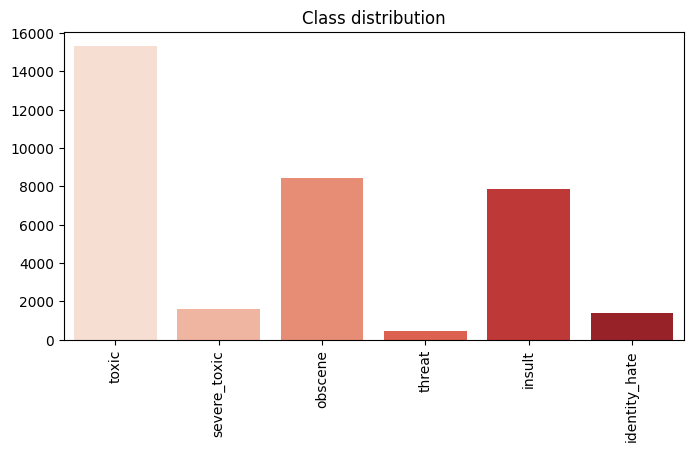

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x= label_count.index, y = label_count.values, palette= sns.color_palette("Reds"))
plt.xticks(rotation=90)
plt.title('Class distribution', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Distribution of comment Lengths')

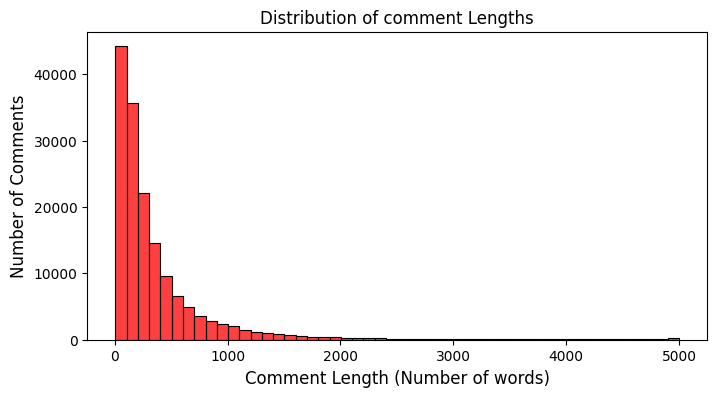

In [ ]:
comment_len = train_df.comment_text.str.len()

# plot the distribution of comment lengths
plt.figure(figsize=(8,4))
sns.histplot(comment_len, kde=False, bins=50, color="red")
plt.xlabel("Comment Length (Number of words)", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Distribution of comment Lengths", fontsize=12)

In [ ]:
train_df.drop(['id'], inplace = True, axis = 1)
train_df['labels'] = train_df.iloc[:,1:].values.tolist()
train_df.drop(train_df.columns.values[1:-1].tolist(),inplace = True, axis = 1)
train_df.head()

,comment_text,labels
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


In [ ]:
train_df["drop"] = train_df.labels.apply(lambda column: column == [0,0,0,0,0,0])

In [ ]:
train_df["drop"].sum() # number of no hate comments
# lets remove 100000 of them so that it becomes even with other classes

143346

In [ ]:
train_df = train_df.drop(train_df[train_df['drop']].sample(frac=.8).index)

In [ ]:
train_df['comment_text'] = train_df["comment_text"].str.lower()
train_df['comment_text'] = train_df["comment_text"].str.replace('\xa0', " ",regex = False).str.split().str.join(" ")

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05

In [ ]:
class ToxicityDataset(Dataset):
    def __init__(self, tokenizer, comments, labels, max_len, evaluation_mode=False):
        self.tokenizer = tokenizer
        self.text = comments
        self.eval_mode = evaluation_mode
        self.targets = labels
        self.max_len = max_len

    def __getitem__(self, idx):
        text = str(self.text[idx])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        out = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float)
        }

        return out


    def __len__(self):
        return len(self.targets)

In [ ]:
comments = train_df.comment_text.tolist()
labels = train_df.labels.to_list()

In [ ]:
len(comments), len(labels)

(44894, 44894)

In [ ]:
train_text, eval_text, train_labels, eval_labels = train_test_split(comments, labels, test_size=0.15)
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size=0.20)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
training_dataset = ToxicityDataset(tokenizer, train_text, labels=train_labels, max_len=MAX_LEN)
eval_dataset = ToxicityDataset(tokenizer, eval_text, labels=eval_labels, max_len=MAX_LEN)
test_dataset = ToxicityDataset(tokenizer, test_text, labels=test_labels, max_len=MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }
training_loader = DataLoader(training_dataset, **train_params)
eval_loader = DataLoader(eval_dataset, **train_params)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(768, 6)
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:, 0]
        out = self.classifier(out)
        return out

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
num_training_steps = EPOCHS * len(training_loader)
lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
task = "multilabel"
num_labels = 6

accuracy = torchmetrics.Accuracy(task=task, num_labels=num_labels).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(task, num_labels=num_labels).to(device)
f1_score = torchmetrics.F1Score(task,num_labels=num_labels).to(device)
roc = torchmetrics.ROC(task, num_labels=num_labels).to(device)

In [ ]:
def train_model(epoch):
    model.train()
    loss_batch = []
    accuracy_batch = []
    with tqdm(training_loader, desc=f"Epoch {epoch+1}") as pbar:
      for idx, data in enumerate(training_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)

          outputs = model(ids, mask, token_type_ids)

          optimizer.zero_grad()
          loss = loss_fn(outputs, targets)
          acc = accuracy(outputs, targets)
          f1 = f1_score(outputs, targets)
          pbar.set_postfix({
              "Loss": loss.item(),
              "Accuracy": acc.item(),
              "F1-Score": f1.item()
          })

          loss.backward()
          optimizer.step()
          lr_scheduler.step()
          pbar.update()


def evaluate_model(data_loader):
    model.eval()
    target_vals = []
    preds = []
    with tqdm(data_loader) as pbar:
      for idx, data in enumerate(data_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          with torch.no_grad():
            outputs = model(ids, mask, token_type_ids)

          loss = loss_fn(outputs, targets)
          acc = accuracy(outputs, targets)
          f1 = f1_score(outputs, targets)
          pbar.set_postfix({
              "Loss": loss.item(),
              "Accuracy": acc.item(),
              "F1-Score": f1.item()
          })
          preds.append(outputs)
          target_vals.append(targets)

          pbar.update()
    preds = torch.cat(preds)
    target_vals = torch.cat(target_vals)
    print(f"\nAccuracy: {accuracy(preds, target_vals)} F1-Score: {f1_score(preds, target_vals)}")


In [ ]:
for epoch in range(EPOCHS):
  train_model(epoch)
  evaluate_model(eval_loader)

Epoch 1:   0%|          | 0/1908 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 421/421 [02:02<00:00,  3.43it/s, 


Accuracy: 0.9506062865257263 F1-Score: 0.8147047758102417


100%|██████████| 421/421 [02:02<00:00,  3.44it/s, Loss=0.073, Accuracy=0.967, F1-Score=0.824]



Accuracy: 0.9518683552742004 F1-Score: 0.8186818361282349


100%|██████████| 421/421 [02:02<00:00,  3.44it/s, Loss=0.0518, Accuracy=0.978, F1-Score=0.909]



Accuracy: 0.9523880481719971 F1-Score: 0.818661630153656


Epoch 4:  15%|█▌        | 295/1908 [03:37<19:48,  1.36it/s, Loss=0.0563, Accuracy=0.969, F1-Score=0.824]


KeyboardInterrupt: ignored

In [ ]:
evaluate_model(test_loader)

100%|██████████| 477/477 [02:18<00:00,  3.44it/s, Loss=0.0811, Accuracy=0.958, F1-Score=0.818]


Accuracy: 0.9537473917007446 F1-Score: 0.825736403465271


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Datasets/model_state_dict.pt")

In [ ]:
torch.save(model, "/content/drive/MyDrive/Datasets/whole_model.pt")